In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [60]:
# test は使わない
import pandas as pd

test = pd.read_csv('test.csv')
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


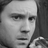

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

img_pix = train.iat[0, 1]
img = np.array(img_pix.split(' ')).astype(np.int32)
img = img.reshape(48, 48)
img = Image.fromarray(img).convert('L')

img

In [6]:
# dataset（x_train）作成
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

for index in range(len(train)):
    if index > 20000 and index % 100 == 0:
        print('now processing {}-th data'.format(index))
    elif index % 3000 == 0:
        print('now processing {}-th data'.format(index))
    
    img_pix = train.iat[index, 1]
    img_ = np.array(img_pix.split(' ')).astype(np.int32)
    img_ = img_.reshape(1, 48, 48)
    #img_ = Image.fromarray(img_).convert('L')
    if index == 0:
        img = img_
    else:
        img = np.vstack([img, img_])

now processing 0-th data
now processing 3000-th data
now processing 6000-th data
now processing 9000-th data
now processing 12000-th data
now processing 15000-th data
now processing 18000-th data
now processing 20100-th data
now processing 20200-th data
now processing 20300-th data
now processing 20400-th data
now processing 20500-th data
now processing 20600-th data
now processing 20700-th data
now processing 20800-th data
now processing 20900-th data
now processing 21000-th data
now processing 21100-th data
now processing 21200-th data
now processing 21300-th data
now processing 21400-th data
now processing 21500-th data
now processing 21600-th data
now processing 21700-th data
now processing 21800-th data
now processing 21900-th data
now processing 22000-th data
now processing 22100-th data
now processing 22200-th data
now processing 22300-th data
now processing 22400-th data
now processing 22500-th data
now processing 22600-th data
now processing 22700-th data
now processing 22800-

In [8]:
np.save('facedataset', img)

In [1]:
import numpy as np
img = np.load('facedataset.npy')

### label データ用意

In [6]:
import pandas as pd
label = pd.read_csv('fer2013new.csv')
label.head()

,Usage,Image name,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt,unknown,NF
0,Training,fer0000000.png,4,0,0,1,3,2,0,0,0,0
1,Training,fer0000001.png,6,0,1,1,0,0,0,0,2,0
2,Training,fer0000002.png,5,0,0,3,1,0,0,0,1,0
3,Training,fer0000003.png,4,0,0,4,1,0,0,0,1,0
4,Training,fer0000004.png,9,0,0,1,0,0,0,0,0,0


In [56]:
label[label['Usage'] == 'Training'].shape

(28709, 12)

In [7]:
y = label[label['Usage'] == 'Training']
y = y.drop(['Usage', 'Image name', 'unknown', 'NF'], axis=1)
del label
y.head(10)

,neutral,happiness,surprise,sadness,anger,disgust,fear,contempt
0,4,0,0,1,3,2,0,0
1,6,0,1,1,0,0,0,0
2,5,0,0,3,1,0,0,0
3,4,0,0,4,1,0,0,0
4,9,0,0,1,0,0,0,0
5,6,0,0,1,0,0,1,1
6,2,0,0,8,0,0,0,0
7,0,10,0,0,0,0,0,0
8,0,10,0,0,0,0,0,0
9,0,0,6,0,0,0,4,0


In [4]:
y.sum(axis=0)

neutral      85563
happiness    73454
surprise     33074
sadness      38538
anger        22522
disgust       4247
fear          9641
contempt      4845
dtype: int64

In [4]:
from keras import layers
from keras import models
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import os

# GPU setting
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
            gpu_options = tf.GPUOptions(
                visible_device_list="2", # specify GPU number
                allow_growth=True)
        )
set_session(tf.Session(config=config))

K.set_image_data_format(data_format='channels_first')

def resblock(x, filter_num=64, kernel_size=(3, 3)):
    shortcut = x
    shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Conv2D(filter_num, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filter_num, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

def create_model(filter_num=64, block_num=4):
    inputs = layers.Input(shape=[1, 48, 48])
    x = inputs
    
    for i in range(block_num):
        if i > 0:
            x = layers.MaxPooling2D((2,2))(x)
            filter_num = filter_num * 2
        filter_num = [64, 128, 256, 64][i]
        x = layers.Conv2D(filter_num, (3,3), padding="same")(x)
        x = resblock(x, filter_num)
        x = resblock(x, filter_num)
        x = resblock(x, filter_num)
    x = layers.GlobalAveragePooling2D()(x)
    y = layers.Dense(8, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=y)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

X = img
Y = y

X = X.reshape(-1, 1, 48, 48)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    width_shift_range=0.2,  # 左右にずらす
    height_shift_range=0.2,  # 上下にずらす
    horizontal_flip=True  # 左右反転
)

baseSaveDir = './log/'
checkpoint = os.path.join(baseSaveDir, 'classifier_{epoch:02d}epoch-loss{val_loss:.2f}-acc{val_acc:.2f}.hdf5')
cp = ModelCheckpoint(filepath = checkpoint, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
csvlogger = CSVLogger('./log/history_face_classifier.csv')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

image_clf = create_model()
image_clf.summary()

history = image_clf.fit_generator(datagen.flow(X_train, y_train, batch_size=100),
                    steps_per_epoch=X_train.shape[0] // 100, epochs=1000,
                    callbacks=[reduce_lr, early_stopping, cp, csvlogger],
                    validation_data=(X_valid, y_valid))

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 48, 48)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 48, 48)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 48, 48)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 48, 48)   192         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation

Epoch 1/1000
229/229 [==============================] - 41s 179ms/step - loss: 16.3690 - acc: 0.3501 - val_loss: 16.2162 - val_acc: 0.3124

Epoch 00001: val_loss improved from inf to 16.21615, saving model to ./log/classifier_01epoch-loss16.22-acc0.31.hdf5
Epoch 2/1000
229/229 [==============================] - 31s 136ms/step - loss: 15.9484 - acc: 0.3618 - val_loss: 15.6328 - val_acc: 0.4037

Epoch 00002: val_loss improved from 16.21615 to 15.63283, saving model to ./log/classifier_02epoch-loss15.63-acc0.40.hdf5
Epoch 3/1000
229/229 [==============================] - 31s 136ms/step - loss: 15.1942 - acc: 0.4207 - val_loss: 18.9777 - val_acc: 0.2948

Epoch 00003: val_loss did not improve from 15.63283
Epoch 4/1000
229/229 [==============================] - 31s 136ms/step - loss: 13.2707 - acc: 0.5597 - val_loss: 11.8744 - val_acc: 0.6254

Epoch 00004: val_loss improved from 15.63283 to 11.87443, saving model to ./log/classifier_04epoch-loss11.87-acc0.63.hdf5
Epoch 5/1000
229/229 [=====

In [4]:
# create a VGG19-wise model
from keras import layers
from keras import models
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import os

# GPU setting
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
            gpu_options = tf.GPUOptions(
                visible_device_list="2", # specify GPU number
                allow_growth=True)
        )
set_session(tf.Session(config=config))

K.set_image_data_format(data_format='channels_first')

img_input = layers.Input(shape=[1, 48, 48])
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x) # 128
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x) # 128
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x) # 256
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x) # 256
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv3')(x) # 256 -> 128
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv4')(x) # 256 -> 128
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
#x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

x = layers.Flatten(name='flatten')(x)
x = layers.Dense(100, name='fc1')(x)
x = layers.ReLU(name='relu')(x)
x = layers.Dense(1024, activation='relu', name='fc2')(x)
x = layers.Dense(8, activation='softmax', name='predictions')(x)

image_clf = models.Model(inputs=img_input, outputs=x, name='imageClf')
image_clf.summary()

X = img
Y = y

X = X.reshape(-1, 1, 48, 48)

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    width_shift_range=0.2,  # 左右にずらす
    height_shift_range=0.2,  # 上下にずらす
    horizontal_flip=True  # 左右反転
)

baseSaveDir = './log/'
checkpoint = os.path.join(baseSaveDir, 'classifier_{epoch:02d}epoch-loss{val_loss:.2f}-acc{val_acc:.2f}.hdf5')
cp = ModelCheckpoint(filepath = checkpoint, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
csvlogger = CSVLogger('./log/history_face_classifier.csv')

image_clf.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

history = image_clf.fit_generator(datagen.flow(X_train, y_train, batch_size=100),
                    steps_per_epoch=X_train.shape[0] // 100, epochs=1000,
                    callbacks=[reduce_lr, early_stopping, cp, csvlogger],
                    validation_data=(X_valid, y_valid))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 48, 48)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 48, 48)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 48, 48)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 24, 24)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 24, 24)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 24, 24)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 12, 12)       0         
__________

229/229 [==============================] - 8s 34ms/step - loss: 8.1649 - acc: 0.8143 - val_loss: 8.5494 - val_acc: 0.7887

Epoch 00024: val_loss improved from 8.60148 to 8.54945, saving model to ./log/classifier_24epoch-loss8.55-acc0.79.hdf5
Epoch 25/1000
229/229 [==============================] - 8s 35ms/step - loss: 8.1336 - acc: 0.8143 - val_loss: 8.6894 - val_acc: 0.7699

Epoch 00025: val_loss did not improve from 8.54945
Epoch 26/1000
229/229 [==============================] - 8s 34ms/step - loss: 8.0572 - acc: 0.8201 - val_loss: 8.5367 - val_acc: 0.7889

Epoch 00026: val_loss improved from 8.54945 to 8.53667, saving model to ./log/classifier_26epoch-loss8.54-acc0.79.hdf5
Epoch 27/1000
229/229 [==============================] - 8s 33ms/step - loss: 8.0067 - acc: 0.8217 - val_loss: 8.5481 - val_acc: 0.7926

Epoch 00027: val_loss did not improve from 8.53667
Epoch 28/1000
229/229 [==============================] - 7s 33ms/step - loss: 8.0074 - acc: 0.8196 - val_loss: 8.6343 - val_ac

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

img_pix = X_valid[5].reshape(48, 48)
imgval = Image.fromarray(img_pix).convert('L')

imgval

In [11]:
image_clf.predict(X_valid[400].reshape(1, 1, 48, 48))

array([[0.10464643, 0.02706969, 0.03146272, 0.27285692, 0.39470023,
        0.08939447, 0.06541893, 0.0144505 ]], dtype=float32)

#### ここまででできたこととこれからやること
- 表情の分類器作成 (done)
- これに自分の顔を通して表情の分類を表す出力を得る
- embedding したベクトルを得て、絵文字を生成

In [20]:
from utils.glove_loader import GloveModel
glove_model = GloveModel()
print("now processing...")
glove_model.load(data_dir_path='../emoji-gan/utils/glove.6B.300d.txt', embedding_dim=300)
emb_dict = glove_model.word2em
print("Done!")

now processing...
Done!


In [31]:
np.linalg.norm(emb_dict['happy'])

5.427634

In [40]:
if (glove_model.encode_doc('hello world').astype(np.float32) == (emb_dict['hello']+emb_dict['world'])).all():
    print("glove_model.encode_doc method is the same as the summation of vectors.")

glove_model.encode_doc method is the same as the summation of vectors.


In [18]:
from PIL import Image

# load image
input_image = Image.open('IMG_5330.jpeg').resize((48, 48), Image.BICUBIC).convert('L')
input_image = np.array(input_image)
input_image = input_image.reshape(1, 1, 48, 48)
result = image_clf.predict(input_image)
result

array([[0.1331738 , 0.00910493, 0.49405387, 0.02679073, 0.15398534,
        0.03346351, 0.1388399 , 0.01058791]], dtype=float32)